In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

import xetcache

from dotenv import load_dotenv

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

#from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.modeling.zoning_models.zoning_tracts_population import TractsModelPopulation
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_model import TractsModel
from cities.utils.data_loader import select_from_sql


root = find_repo_root()


        Usage:

           %%xetmemo input=v1,v2 output=v3,v4

        Caches the specified output variables each time it is called.
        If called later with the same inputs , the cached value is returned
        and not reevaluated. This is persistent across Python runs.

        Any content changes to the input input variables, or cell code will
        force reevaluation of the cell. Otherwise the outputs will simply be
        retrieved from the memo.

        This memo is persistent across Python processes and if XetHub is used
        see `xetcache.set_xet_project`, can be shared with others.

        For performance reasons, only functions which take more than 3
        seconds (configurable from config.set_runtime_threshold) will be 
        cached. "always=True" can be added to the xetmemo arguments to
        ignore the runime and to always cache

           %%xetmemo input=v1,v2 output=v3,v4 always=True

        Note that inputs can be anything picklable including funct

In [2]:

census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",
        "housing_units_original"
        "total_value",
        "total_population",
        "population_density",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        'limit',
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

print(subset['continuous'].keys())

dict_keys(['parcel_sqm', 'mean_limit_original', 'white_original', 'housing_units', 'income', 'university_overlap', 'segregation_original', 'total_population', 'median_distance', 'median_value', 'population_density', 'downtown_overlap'])


In [3]:
ins = [
    ("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),
    ("median_value", "segregation"),
    ("distance", "segregation"),
    ("limit", "sqm"),
    ("segregation", "sqm"),
    ("distance", "white"),
    ("income", "limit"),
    ("downtown_overlap", "median_value"),
    ("downtown_overlap", "segregation"),
    ("median_value", "white"),
    ("distance", "income"),
    # from density/pop stage 1
    ('population', 'sqm'), 
    ('density', 'income'), ('density', 'white'), 
    ('density', 'segregation'), ('density', 'sqm'), 
    ('density', 'downtown_overlap'), ('density', 'university_overlap'), 
    ('population', 'density')
]

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


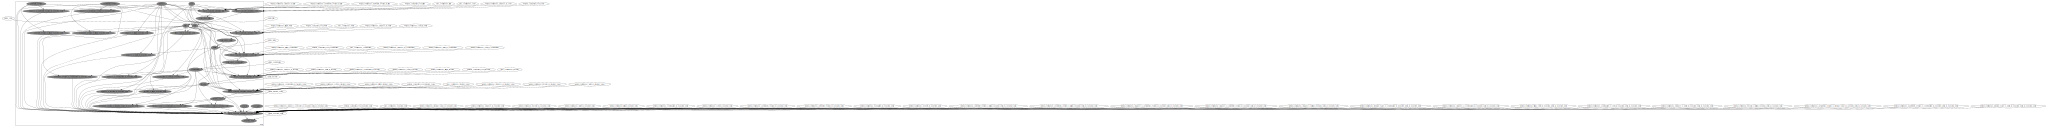

In [4]:
pyro.clear_param_store()

tracts_model = TractsModelPopulation(
    **subset,
    housing_units_continuous_interaction_pairs = ins
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)


assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

[iteration 0001] loss: 304163.5938
[iteration 0050] loss: 27907.5586
[iteration 0100] loss: 19189.6211
[iteration 0150] loss: 16820.3496
[iteration 0200] loss: 15972.0264
[iteration 0250] loss: 16402.7695
[iteration 0300] loss: 14735.9102
[iteration 0350] loss: 14556.0811
[iteration 0400] loss: 14444.9863
[iteration 0450] loss: 14398.8779
[iteration 0500] loss: 14323.4072
[iteration 0550] loss: 14223.3594
[iteration 0600] loss: 14166.8311
[iteration 0650] loss: 14385.5576
[iteration 0700] loss: 14121.1709
[iteration 0750] loss: 14080.2568
[iteration 0800] loss: 14158.9404
[iteration 0850] loss: 14029.1484
[iteration 0900] loss: 13993.9238
[iteration 0950] loss: 13989.0254
[iteration 1000] loss: 13937.2852
[iteration 1050] loss: 13912.7090
[iteration 1100] loss: 14005.9043
[iteration 1150] loss: 13961.1162
[iteration 1200] loss: 13951.5771
[iteration 1250] loss: 13859.9619
[iteration 1300] loss: 13857.4648
[iteration 1350] loss: 13934.3613
[iteration 1400] loss: 13880.9756
[iteration 14

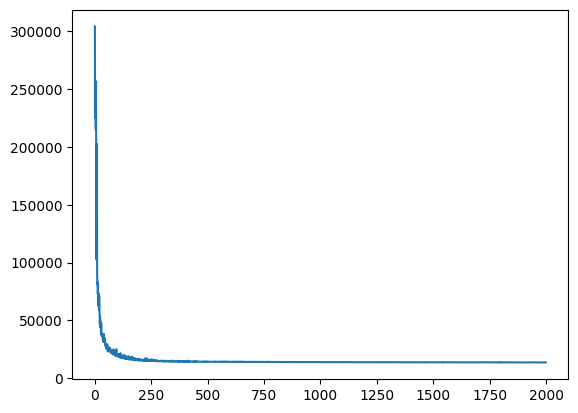

tensor(2786.7720, grad_fn=<MulBackward0>)
Writing to 4fedc28af06e76ee5b23f48cc5da7bddc26318f8d57f9f6f1d0518cfd6908ff4.pickle


/home/rafal/.local/lib/python3.10/site-packages/torch/utils/hooks.py:87: UserWarning: backward hook <function warn_if_nan.<locals>.<lambda> at 0x7fc2916a69e0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn(f"backward hook {repr(hook)} on tensor will not be "
/home/rafal/.local/lib/python3.10/site-packages/torch/utils/hooks.py:87: UserWarning: backward hook <function warn_if_inf.<locals>.<lambda> at 0x7fc2916a65f0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn(f"backward hook {repr(hook)} on tensor will not be "


In [5]:
%%xetmemo input=tracts_model,n_steps,subset output=guide,waic

pyro.clear_param_store()
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

waic = compute_waic(
    model=tracts_model,
    guide=guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic['waic'])  # interaction model: ca 2720-2780

# just population: seemingly higher, 2900,
# but crossvalidation results are slightly better than mere interactions 
# just density  around 2800-2800
#population + density => approx 2800



In [6]:
population_preds_path = "population_preds.dill"


predictive = Predictive(tracts_model, guide=guide, num_samples=1000)

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"] #, "white", "segregation", "income", "median_value"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


preds = predictive(**subset_for_preds)


if not os.path.exists(population_preds_path):
    with open(population_preds_path, "wb") as f:
        dill.dump(preds, f)

[iteration 0001] loss: 170014.9219
[iteration 0050] loss: 47823.0469
[iteration 0100] loss: 23320.0352
[iteration 0150] loss: 18947.0645
[iteration 0200] loss: 14173.3662
[iteration 0250] loss: 12608.4775
[iteration 0300] loss: 12033.2188
[iteration 0350] loss: 11214.0645
[iteration 0400] loss: 10628.8740
[iteration 0450] loss: 11040.3125
[iteration 0500] loss: 9938.3418
[iteration 0550] loss: 9999.7588
[iteration 0600] loss: 9678.2930
[iteration 0650] loss: 9437.6104
[iteration 0700] loss: 9249.2012
[iteration 0750] loss: 9364.4102
[iteration 0800] loss: 9204.8955
[iteration 0850] loss: 9137.5752
[iteration 0900] loss: 8995.0088
[iteration 0950] loss: 9007.4639
[iteration 1000] loss: 8908.0635
[iteration 1050] loss: 8975.6123
[iteration 1100] loss: 8881.3379
[iteration 1150] loss: 8787.6455
[iteration 1200] loss: 8814.0518
[iteration 1250] loss: 8899.0410
[iteration 1300] loss: 8831.9238
[iteration 1350] loss: 8811.7256
[iteration 1400] loss: 8766.2930
[iteration 1450] loss: 8785.9404

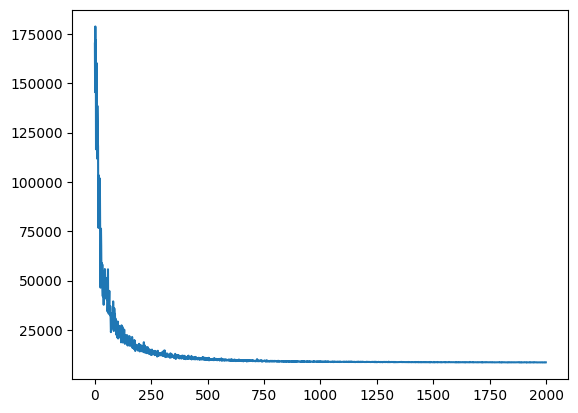

/home/rafal/s78projects/cities/cities/modeling/zoning_models/zoning_tracts_population.py:66: UserWarning: Passed categorical_levels will no longer override the levels passed to or computed during model initialization. The argument will be ignored.
  warnings.warn(


tensor(0.5043) tensor(0.2549)


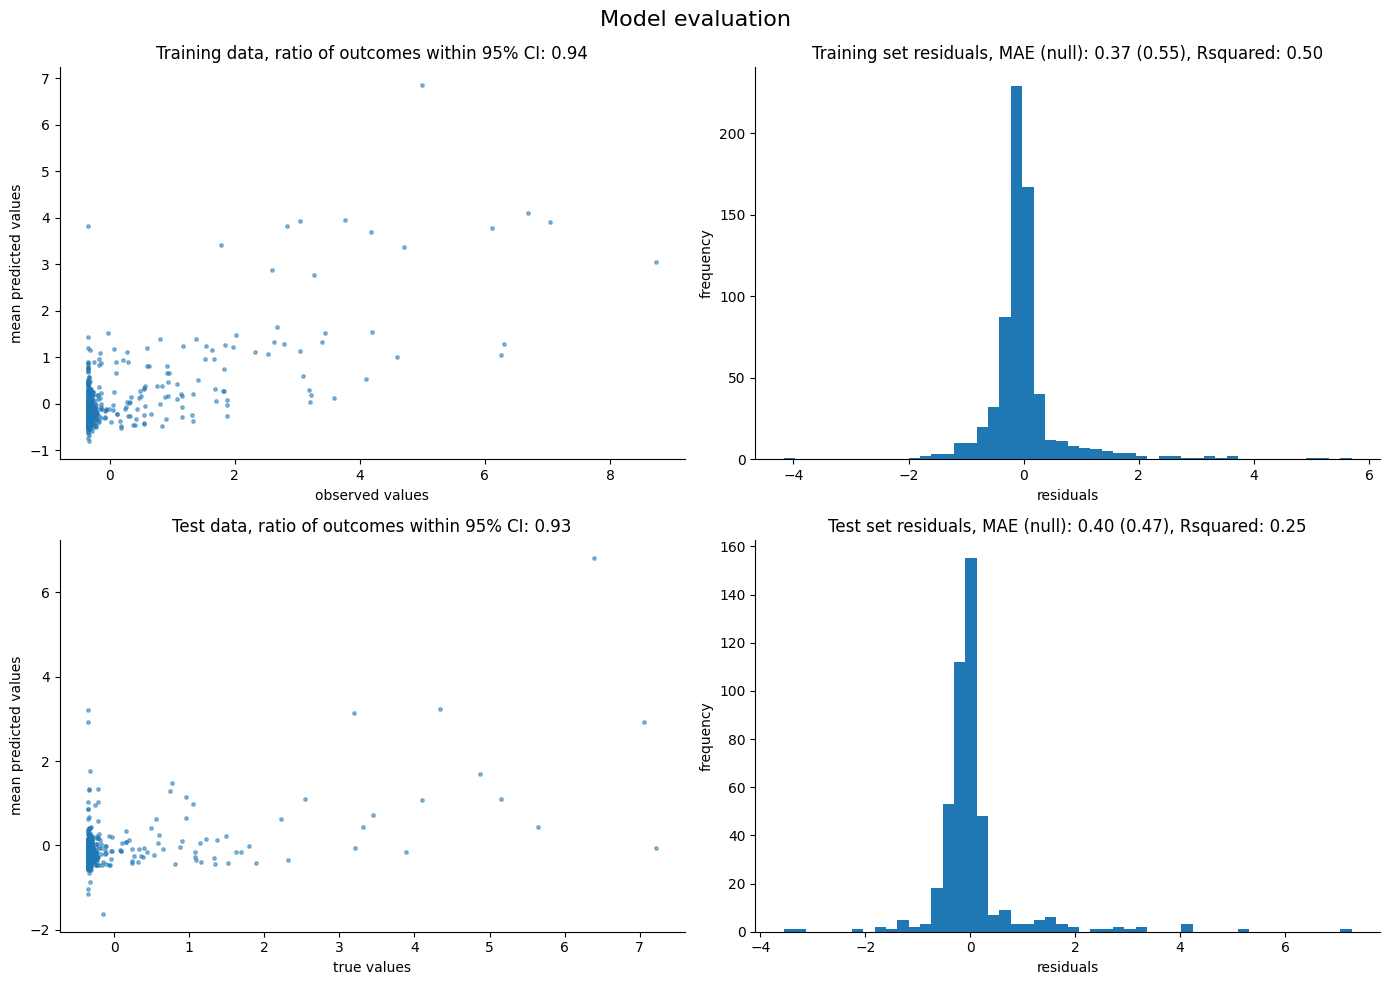

MAE improvements on the original scale: (tensor(37.), tensor(47.))
Writing to e6d30aa81695580fb3fc1699a7221a45cfa2ef4804b7611685374c9b553480b4.pickle


In [7]:
%%xetmemo input=tracts_model output=performance_results

pyro.clear_param_store()

train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path, train_size=0.6
)

performance_results = test_performance(
    tracts_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


mae_improvement_train = destandardize_housing_units(
    performance_results["mae_null_train"] - performance_results["mae_train"]
)
mae_improvement_test = destandardize_housing_units(
    performance_results["mae_null_test"] - performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
)

In [8]:
university_overlap = subset['continuous']['university_overlap'].detach().numpy()
downtown_overlap = subset['continuous']['downtown_overlap'].detach().numpy()
units_observed = subset['continuous']['housing_units'].detach().numpy()

units_predicted = preds['housing_units'].mean(dim = 0).detach().numpy()

residuals = units_observed - units_predicted

bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

university_bin_indices = np.digitize(university_overlap, bins=bins) - 1 
downtown_bin_indices = np.digitize(downtown_overlap, bins=bins) - 1

grouped_residuals_university = [residuals[university_bin_indices == i] for i in range(len(bins) - 1)]
grouped_residuals_downtown = [residuals[downtown_bin_indices == i] for i in range(len(bins) - 1)]


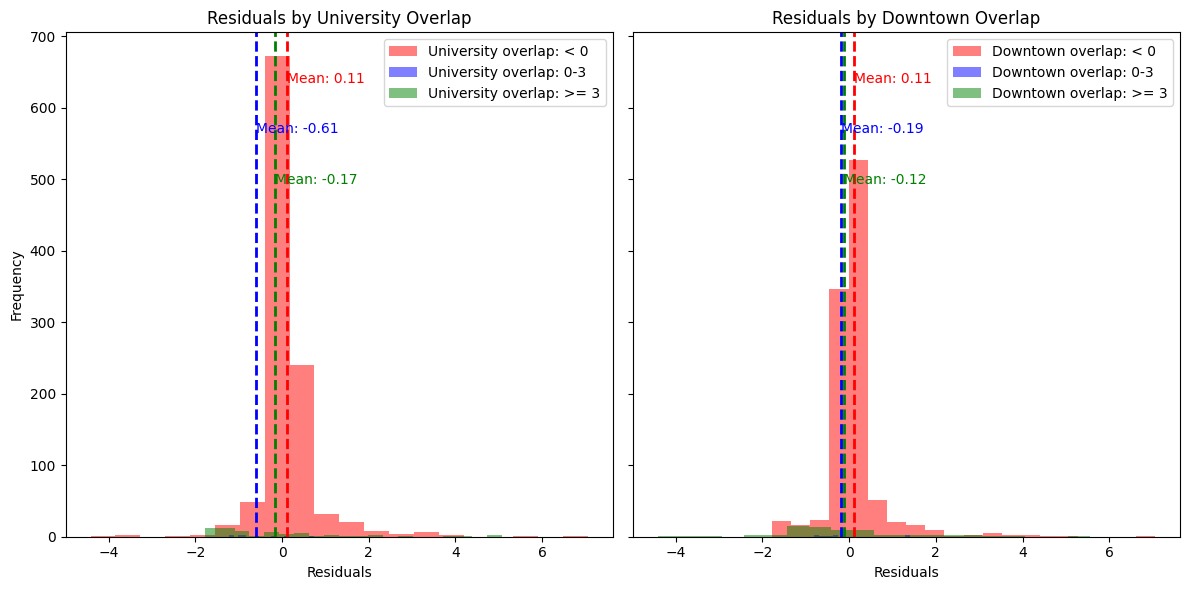

In [9]:
bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

residuals = units_observed - units_predicted

grouped_residuals_university = [residuals[university_bin_indices == i] for i in range(len(bins) - 1)]
grouped_residuals_downtown = [residuals[downtown_bin_indices == i] for i in range(len(bins) - 1)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

colors = ['red', 'blue', 'green']

y_offsets = [0.9, 0.8, 0.7]  # Adjust as needed

for i in range(len(bin_labels)):
    axes[0].hist(grouped_residuals_university[i], bins=20, alpha=0.5, label=f"University overlap: {bin_labels[i]}", color=colors[i])
    
    mean_university = np.mean(grouped_residuals_university[i])
    axes[0].axvline(mean_university, color=colors[i], linestyle='dashed', linewidth=2)
    
    y_position = axes[0].get_ylim()[1] * y_offsets[i]
    axes[0].text(mean_university, y_position, f'Mean: {mean_university:.2f}', color=colors[i])

axes[0].set_title("Residuals by University Overlap")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")
axes[0].legend()

for i in range(len(bin_labels)):
    axes[1].hist(grouped_residuals_downtown[i], bins=20, alpha=0.5, label=f"Downtown overlap: {bin_labels[i]}", color=colors[i])
    
    mean_downtown = np.mean(grouped_residuals_downtown[i])
    axes[1].axvline(mean_downtown, color=colors[i], linestyle='dashed', linewidth=2)
    
    y_position = axes[1].get_ylim()[1] * y_offsets[i]
    axes[1].text(mean_downtown, y_position, f'Mean: {mean_downtown:.2f}', color=colors[i])

axes[1].set_title("Residuals by Downtown Overlap")
axes[1].set_xlabel("Residuals")
axes[1].legend()

plt.tight_layout()
plt.show()


In [10]:
with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit": (torch.tensor(0.0), torch.tensor(1.0))}):
        samples = predictive(**subset_for_preds)

print(samples["limit"].shape)
print(samples["housing_units"].shape)

value = samples["limit"]
outcome = samples["housing_units"]

with mwc:
    observed_limit = gather(value, IndexSet(**{"limit": {0}}), event_dims=0)
    low_limit = gather(value, IndexSet(**{"limit": {1}}), event_dims=0)
    high_limit = gather(value, IndexSet(**{"limit": {2}}), event_dims=0)

    observed_units = gather(outcome, IndexSet(**{"limit": {0}}), event_dims=0)
    low_units = gather(outcome, IndexSet(**{"limit": {1}}), event_dims=0)
    high_units = gather(outcome, IndexSet(**{"limit": {2}}), event_dims=0)


torch.Size([1000, 3, 1, 1, 1, 1130])
torch.Size([1000, 3, 1, 1, 1, 1130])


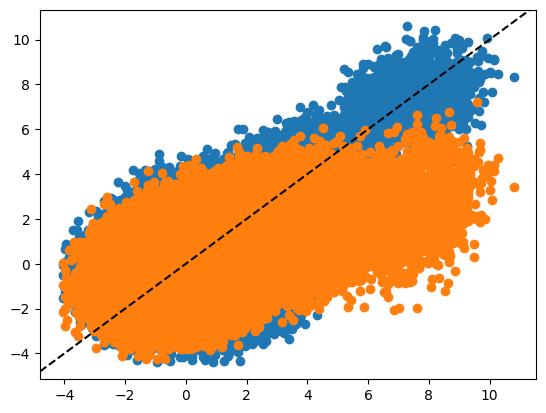

In [11]:
plt.scatter(observed_units, low_units, label="Low limit")
plt.scatter(observed_units, high_units, label="High limit")
plt.axline([0, 0], [1, 1], color="black", linestyle="--")
plt.show()

tensor(-0.0876) tensor(-0.0303) tensor(-0.1907)


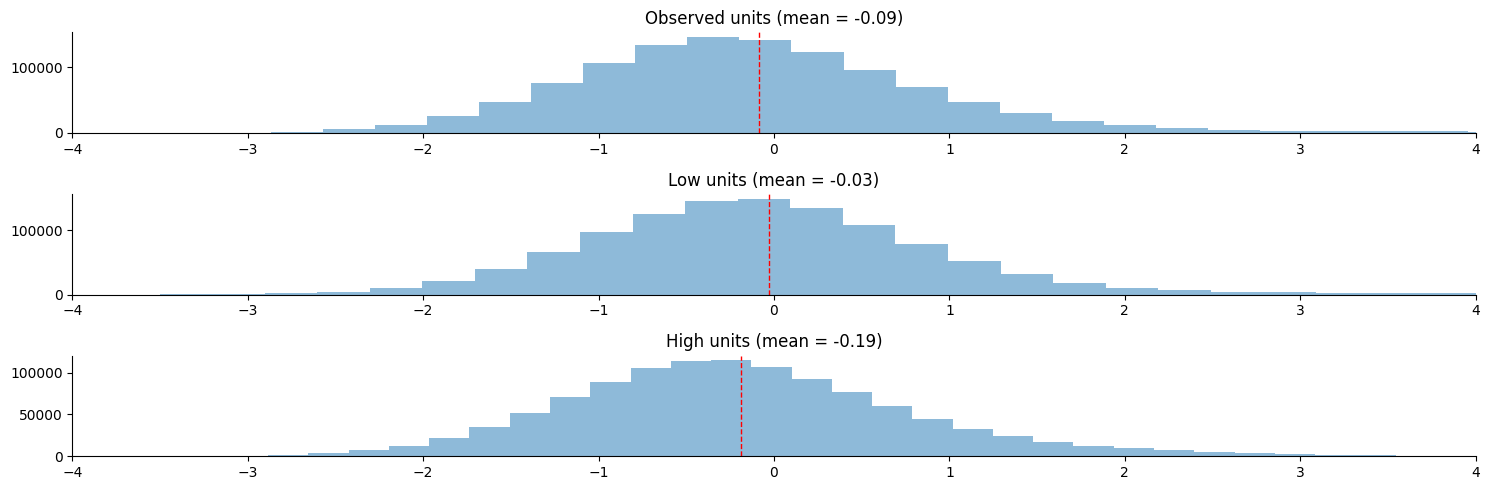

In [12]:

fig, axes = plt.subplots(3, 1, figsize=(15, 5))


observed_mean = observed_units.mean()
low_mean = low_units.mean()
high_mean = high_units.mean()

print(observed_mean, low_mean, high_mean)

axes[0].hist(
    observed_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="observed"
)
axes[0].axvline(observed_mean, color="r", linestyle="dashed", linewidth=1)
axes[0].set_title(f"Observed units (mean = {observed_mean:.2f})")
axes[0].set_xlim(-4, 4)

axes[1].hist(low_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="low")
axes[1].axvline(low_mean, color="r", linestyle="dashed", linewidth=1)
axes[1].set_title(f"Low units (mean = {low_mean:.2f})")
axes[1].set_xlim(-4, 4)

axes[2].hist(high_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="high")
axes[2].axvline(high_mean, color="r", linestyle="dashed", linewidth=1)
axes[2].set_title(f"High units (mean = {high_mean:.2f})")
axes[2].set_xlim(-4, 4)

plt.tight_layout()
sns.despine()
plt.show()

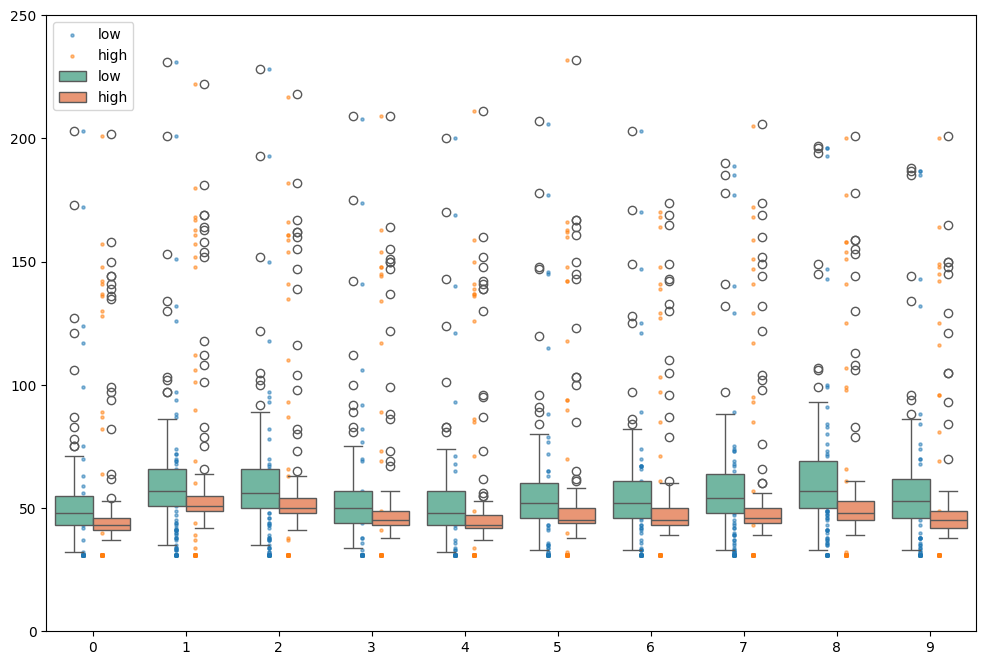

In [13]:
years = data["categorical"]["year"].flatten().detach().numpy()
years_full = years - 0.1
years_no = years + 0.1


plt.figure(figsize=(12, 8))
plt.scatter(
    x=years_full,
    y=destandardize_housing_units(low_units.mean(axis=0).clamp(min=0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="low",
)


plt.scatter(
    x=years_no,
    y=destandardize_housing_units(high_units.mean(axis=0).clamp(min =0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="high",
)


data_combined = np.concatenate(
    (
        destandardize_housing_units(low_units.clamp(min = 0).mean(axis=0).flatten()),
        destandardize_housing_units(high_units.clamp(min=0).mean(axis=0).flatten()),
    )
)
years_combined = np.concatenate((years, years))
labels_combined = np.concatenate(
    (np.repeat("low", len(years)), np.repeat("high", len(years)))
)


boxplot = sns.boxplot(
    x=years_combined,
    y=data_combined,
    hue=labels_combined,
    dodge=True,
    palette="Set2",
   
)

plt.ylim(0,250)
plt.legend()
plt.show()

## Search for useful interactions

In [10]:
hu_parent_names = [
            "median_value",
            "distance",
            "income",
            "white",
            "limit",
            "segregation",
            "sqm",
            "downtown_overlap",
            "university_overlap",
            "density",
        ]

all_pairs = [(name1, name) for name1 in ("population", "density") for name 
             in hu_parent_names]

living_pairs = [pair for pair in all_pairs if pair not in ins]


living_pairs = [
    (x, y) for (x, y) in living_pairs
    if x < y 
] + [("population", "density")]

print(living_pairs)
print(len(living_pairs))

if f'pop_waic_dict_{len(living_pairs)}.pkl' in os.listdir():
    pop_waic_dict = dill.load(open(f'pop_waic_dict_{len(living_pairs)}.pkl', 'rb'))
else:
    pop_waic_dict = {}


print(f"{int(len(pop_waic_dict.keys())/len(living_pairs) * 100)}% pairs done")


[('population', 'white'), ('population', 'segregation'), ('population', 'university_overlap'), ('density', 'median_value'), ('density', 'distance'), ('density', 'limit'), ('population', 'density')]
7
0% pairs done


Running for ('population', 'white')
[iteration 0001] loss: 288079.3438
[iteration 0050] loss: 29750.7363
[iteration 0100] loss: 20696.6660
[iteration 0150] loss: 16289.7686
[iteration 0200] loss: 16538.5176
[iteration 0250] loss: 14804.3574
[iteration 0300] loss: 14862.5127
[iteration 0350] loss: 14730.5566
[iteration 0400] loss: 14696.2314
[iteration 0450] loss: 14469.7725
[iteration 0500] loss: 14320.8018
[iteration 0550] loss: 14226.9707
[iteration 0600] loss: 14309.8945
[iteration 0650] loss: 14190.4014
[iteration 0700] loss: 14153.4609
[iteration 0750] loss: 14132.3350
[iteration 0800] loss: 14179.7412
[iteration 0850] loss: 14219.5762
[iteration 0900] loss: 14042.2842
[iteration 0950] loss: 13954.5547
[iteration 1000] loss: 13987.5322
[iteration 1050] loss: 14073.5029
[iteration 1100] loss: 13907.4629
[iteration 1150] loss: 13902.2012
[iteration 1200] loss: 13947.7852


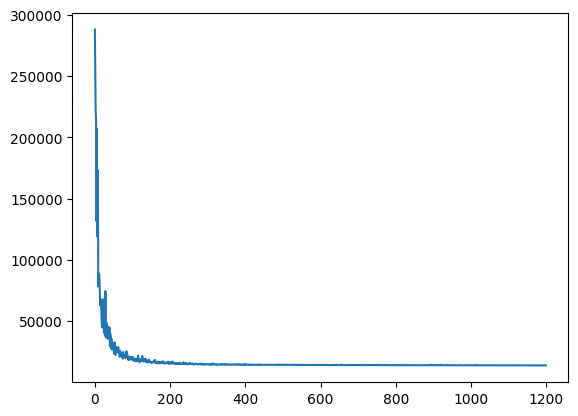

{('population', 'white'): tensor(2872.2087, grad_fn=<MulBackward0>)}
Running for ('population', 'segregation')
[iteration 0001] loss: 342056.8438
[iteration 0050] loss: 28024.5391
[iteration 0100] loss: 25819.5352
[iteration 0150] loss: 16765.8711
[iteration 0200] loss: 16621.5977
[iteration 0250] loss: 15650.3252
[iteration 0300] loss: 14982.3994
[iteration 0350] loss: 14950.8818
[iteration 0400] loss: 14614.8984
[iteration 0450] loss: 14430.6982
[iteration 0500] loss: 14403.7314
[iteration 0550] loss: 14316.0439
[iteration 0600] loss: 14322.6680
[iteration 0650] loss: 14288.0830
[iteration 0700] loss: 14146.4268
[iteration 0750] loss: 14153.6680
[iteration 0800] loss: 14046.4180
[iteration 0850] loss: 14123.5117
[iteration 0900] loss: 14005.3066
[iteration 0950] loss: 14070.3535
[iteration 1000] loss: 13991.4102
[iteration 1050] loss: 14042.1201
[iteration 1100] loss: 14048.0703
[iteration 1150] loss: 13941.9814
[iteration 1200] loss: 13926.4658


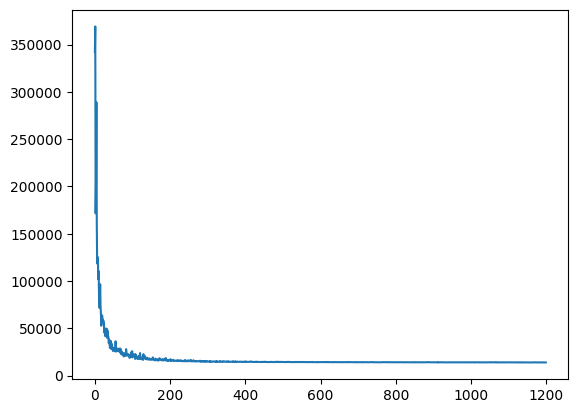

{('population', 'white'): tensor(2872.2087, grad_fn=<MulBackward0>), ('population', 'segregation'): tensor(2780.7793, grad_fn=<MulBackward0>)}
Running for ('population', 'university_overlap')
[iteration 0001] loss: 386234.7188
[iteration 0050] loss: 25967.1953
[iteration 0100] loss: 19107.3867
[iteration 0150] loss: 16904.1504
[iteration 0200] loss: 16997.7656
[iteration 0250] loss: 15838.9209
[iteration 0300] loss: 14817.5254
[iteration 0350] loss: 14638.1953
[iteration 0400] loss: 14483.8584
[iteration 0450] loss: 14482.2070
[iteration 0500] loss: 14376.8066
[iteration 0550] loss: 14463.5186
[iteration 0600] loss: 14242.7402
[iteration 0650] loss: 14208.1582
[iteration 0700] loss: 14109.4141
[iteration 0750] loss: 14202.9268
[iteration 0800] loss: 14078.8047
[iteration 0850] loss: 14078.9043
[iteration 0900] loss: 14025.2920
[iteration 0950] loss: 14078.5693
[iteration 1000] loss: 14016.9160
[iteration 1050] loss: 14075.6816
[iteration 1100] loss: 14028.6035
[iteration 1150] loss: 13

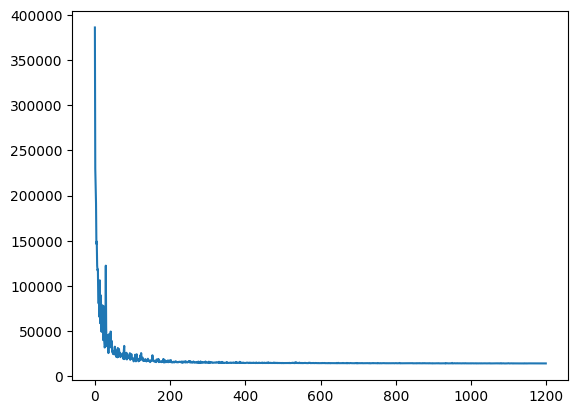

{('population', 'white'): tensor(2872.2087, grad_fn=<MulBackward0>), ('population', 'segregation'): tensor(2780.7793, grad_fn=<MulBackward0>), ('population', 'university_overlap'): tensor(2845.3518, grad_fn=<MulBackward0>)}
Running for ('density', 'median_value')
[iteration 0001] loss: 382194.9062
[iteration 0050] loss: 26781.4141
[iteration 0100] loss: 21921.9688
[iteration 0150] loss: 16930.8027
[iteration 0200] loss: 15821.7393
[iteration 0250] loss: 15097.3604
[iteration 0300] loss: 15095.0352
[iteration 0350] loss: 14946.5469
[iteration 0400] loss: 14484.9336
[iteration 0450] loss: 14375.4961
[iteration 0500] loss: 14648.7441
[iteration 0550] loss: 14336.7832
[iteration 0600] loss: 14372.5645
[iteration 0650] loss: 14237.7217
[iteration 0700] loss: 14178.5078
[iteration 0750] loss: 14172.5400
[iteration 0800] loss: 14114.5967
[iteration 0850] loss: 14127.1875
[iteration 0900] loss: 14139.8447
[iteration 0950] loss: 14086.6104
[iteration 1000] loss: 14021.2822
[iteration 1050] loss

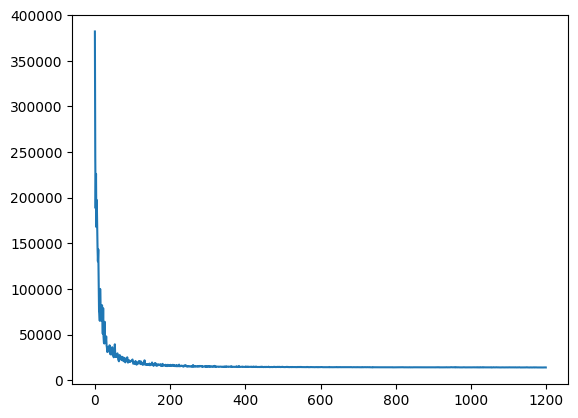

{('population', 'white'): tensor(2872.2087, grad_fn=<MulBackward0>), ('population', 'segregation'): tensor(2780.7793, grad_fn=<MulBackward0>), ('population', 'university_overlap'): tensor(2845.3518, grad_fn=<MulBackward0>), ('density', 'median_value'): tensor(2853.1028, grad_fn=<MulBackward0>)}
Running for ('density', 'distance')
[iteration 0001] loss: 533612.1875
[iteration 0050] loss: 29720.1289
[iteration 0100] loss: 20551.5293
[iteration 0150] loss: 17362.4258
[iteration 0200] loss: 16832.1328
[iteration 0250] loss: 15324.8477
[iteration 0300] loss: 14909.0264
[iteration 0350] loss: 14698.1787
[iteration 0400] loss: 14569.0664
[iteration 0450] loss: 14680.6621
[iteration 0500] loss: 14419.8438
[iteration 0550] loss: 14332.1875
[iteration 0600] loss: 14306.5371
[iteration 0650] loss: 14231.2383
[iteration 0700] loss: 14132.7021
[iteration 0750] loss: 14183.9814
[iteration 0800] loss: 14215.8936
[iteration 0850] loss: 14072.6885
[iteration 0900] loss: 14389.8955
[iteration 0950] loss

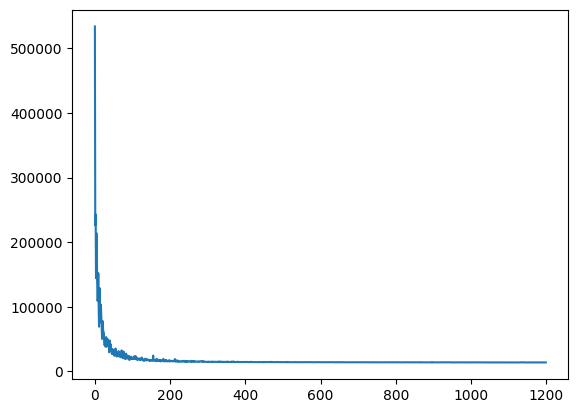

{('population', 'white'): tensor(2872.2087, grad_fn=<MulBackward0>), ('population', 'segregation'): tensor(2780.7793, grad_fn=<MulBackward0>), ('population', 'university_overlap'): tensor(2845.3518, grad_fn=<MulBackward0>), ('density', 'median_value'): tensor(2853.1028, grad_fn=<MulBackward0>), ('density', 'distance'): tensor(2822.2815, grad_fn=<MulBackward0>)}
Running for ('density', 'limit')
[iteration 0001] loss: 375959.2188
[iteration 0050] loss: 29216.1035
[iteration 0100] loss: 22304.6387
[iteration 0150] loss: 20456.8750
[iteration 0200] loss: 16620.5195
[iteration 0250] loss: 15596.0684
[iteration 0300] loss: 15072.2422
[iteration 0350] loss: 14597.1006
[iteration 0400] loss: 14766.9551
[iteration 0450] loss: 14324.3506
[iteration 0500] loss: 14370.7080
[iteration 0550] loss: 14328.4873
[iteration 0600] loss: 14318.7559
[iteration 0650] loss: 14242.8389
[iteration 0700] loss: 14203.5508
[iteration 0750] loss: 14228.3594
[iteration 0800] loss: 14139.3809
[iteration 0850] loss: 1

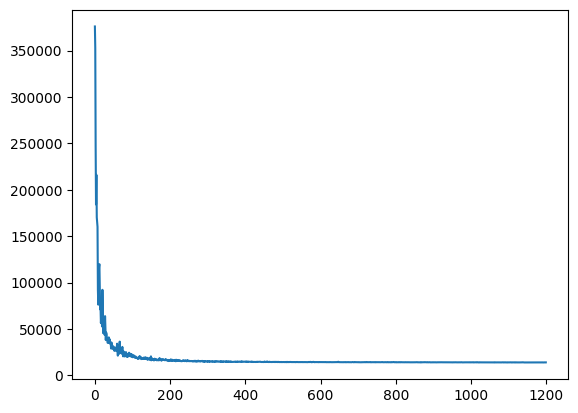

{('population', 'white'): tensor(2872.2087, grad_fn=<MulBackward0>), ('population', 'segregation'): tensor(2780.7793, grad_fn=<MulBackward0>), ('population', 'university_overlap'): tensor(2845.3518, grad_fn=<MulBackward0>), ('density', 'median_value'): tensor(2853.1028, grad_fn=<MulBackward0>), ('density', 'distance'): tensor(2822.2815, grad_fn=<MulBackward0>), ('density', 'limit'): tensor(2861.1687, grad_fn=<MulBackward0>)}
Running for ('population', 'density')


RuntimeError: Multiple sample sites named 'population_x_density_to_housing_units'
                                        Trace Shapes:          
                                         Param Sites:          
                                        Sample Sites:          
                                            data dist      |   
                                                value 1130 |   
                                            year dist 1130 |   
                                                value 1130 |   
                                        distance dist 1130 |   
                                                value 1130 |   
                                downtown_overlap dist 1130 |   
                                                value 1130 |   
                              university_overlap dist 1130 |   
                                                value 1130 |   
                                      population dist 1130 |   
                                                value 1130 |   
                                         density dist 1130 |   
                                                value 1130 |   
                                       sigma_sqm dist      |   
                                                value      |   
                             bias_continuous_sqm dist      |   
                                                value      |   
               weight_continuous_distance_to_sqm dist      |   
                                                value      |   
                    weights_categorical_year_sqm dist      | 10
                                                value      | 10
                     mean_outcome_prediction_sqm dist 1130 |   
                                                value 1130 |   
                                             sqm dist 1130 |   
                                                value 1130 |   
                           bias_continuous_limit dist      |   
                                                value      |   
             weight_continuous_distance_to_limit dist      |   
                                                value      |   
     weight_continuous_downtown_overlap_to_limit dist      |   
                                                value      |   
   weight_continuous_university_overlap_to_limit dist      |   
                                                value      |   
                  weights_categorical_year_limit dist      | 10
                                                value      | 10
                                     sigma_limit dist      |   
                                                value      |   
                   mean_outcome_prediction_limit dist 1130 |   
                                                value 1130 |   
                               child_probs_limit dist 1130 |   
                                                value 1130 |   
                                           limit dist 1130 |   
                                                value 1130 |   
                           bias_continuous_white dist      |   
                                                value      |   
             weight_continuous_distance_to_white dist      |   
                                                value      |   
                  weight_continuous_sqm_to_white dist      |   
                                                value      |   
                weight_continuous_limit_to_white dist      |   
                                                value      |   
                  weights_categorical_year_white dist      | 10
                                                value      | 10
                                     sigma_white dist      |   
                                                value      |   
                   mean_outcome_prediction_white dist 1130 |   
                                                value 1130 |   
                               child_probs_white dist 1130 |   
                                                value 1130 |   
                                           white dist 1130 |   
                                                value 1130 |   
                     bias_continuous_segregation dist      |   
                                                value      |   
       weight_continuous_distance_to_segregation dist      |   
                                                value      |   
          weight_continuous_white_to_segregation dist      |   
                                                value      |   
            weight_continuous_sqm_to_segregation dist      |   
                                                value      |   
          weight_continuous_limit_to_segregation dist      |   
                                                value      |   
            weights_categorical_year_segregation dist      | 10
                                                value      | 10
                               sigma_segregation dist      |   
                                                value      |   
             mean_outcome_prediction_segregation dist 1130 |   
                                                value 1130 |   
                         child_probs_segregation dist 1130 |   
                                                value 1130 |   
                                     segregation dist 1130 |   
                                                value 1130 |   
                                    sigma_income dist      |   
                                                value      |   
                          bias_continuous_income dist      |   
                                                value      |   
            weight_continuous_distance_to_income dist      |   
                                                value      |   
               weight_continuous_white_to_income dist      |   
                                                value      |   
         weight_continuous_segregation_to_income dist      |   
                                                value      |   
                 weight_continuous_sqm_to_income dist      |   
                                                value      |   
               weight_continuous_limit_to_income dist      |   
                                                value      |   
                 weights_categorical_year_income dist      | 10
                                                value      | 10
                  mean_outcome_prediction_income dist 1130 |   
                                                value 1130 |   
                                          income dist 1130 |   
                                                value 1130 |   
                              sigma_median_value dist      |   
                                                value      |   
                    bias_continuous_median_value dist      |   
                                                value      |   
      weight_continuous_distance_to_median_value dist      |   
                                                value      |   
        weight_continuous_income_to_median_value dist      |   
                                                value      |   
         weight_continuous_white_to_median_value dist      |   
                                                value      |   
   weight_continuous_segregation_to_median_value dist      |   
                                                value      |   
           weight_continuous_sqm_to_median_value dist      |   
                                                value      |   
         weight_continuous_limit_to_median_value dist      |   
                                                value      |   
           weights_categorical_year_median_value dist      | 10
                                                value      | 10
            mean_outcome_prediction_median_value dist 1130 |   
                                                value 1130 |   
                                    median_value dist 1130 |   
                                                value 1130 |   
     university_overlap_x_limit_to_housing_units dist 1130 |   
                                                value 1130 |   
       downtown_overlap_x_limit_to_housing_units dist 1130 |   
                                                value 1130 |   
    distance_x_downtown_overlap_to_housing_units dist 1130 |   
                                                value 1130 |   
  distance_x_university_overlap_to_housing_units dist 1130 |   
                                                value 1130 |   
               distance_x_limit_to_housing_units dist 1130 |   
                                                value 1130 |   
     median_value_x_segregation_to_housing_units dist 1130 |   
                                                value 1130 |   
         distance_x_segregation_to_housing_units dist 1130 |   
                                                value 1130 |   
                    limit_x_sqm_to_housing_units dist 1130 |   
                                                value 1130 |   
              segregation_x_sqm_to_housing_units dist 1130 |   
                                                value 1130 |   
               distance_x_white_to_housing_units dist 1130 |   
                                                value 1130 |   
                 income_x_limit_to_housing_units dist 1130 |   
                                                value 1130 |   
downtown_overlap_x_median_value_to_housing_units dist 1130 |   
                                                value 1130 |   
 downtown_overlap_x_segregation_to_housing_units dist 1130 |   
                                                value 1130 |   
           median_value_x_white_to_housing_units dist 1130 |   
                                                value 1130 |   
              distance_x_income_to_housing_units dist 1130 |   
                                                value 1130 |   
               population_x_sqm_to_housing_units dist 1130 |   
                                                value 1130 |   
               density_x_income_to_housing_units dist 1130 |   
                                                value 1130 |   
                density_x_white_to_housing_units dist 1130 |   
                                                value 1130 |   
          density_x_segregation_to_housing_units dist 1130 |   
                                                value 1130 |   
                  density_x_sqm_to_housing_units dist 1130 |   
                                                value 1130 |   
     density_x_downtown_overlap_to_housing_units dist 1130 |   
                                                value 1130 |   
   density_x_university_overlap_to_housing_units dist 1130 |   
                                                value 1130 |   
           population_x_density_to_housing_units dist 1130 |   
                                                value 1130 |   

In [11]:
# initial search pipeline: 
# consider iteractions one by one, record WAIC
# then add bottom 2-4 which improve waic
# then run inference with 2000 steps, check WAIC again
# stop if no stable improvement in WAIC

search_steps = 1200

for pair in living_pairs:
    
    if not pair in pop_waic_dict.keys():
        print(f"Running for {pair}")
        pyro.clear_param_store()
        interaction_set = []
        interaction_set = ins.copy()
        interaction_set.append(pair)
        
        tracts_model = TractsModelPopulation(
        **subset,
        housing_units_continuous_interaction_pairs = interaction_set
        )    

        guide = run_svi_inference(tracts_model, n_steps=search_steps, lr=0.03, **subset)

        waic = compute_waic(
        model=tracts_model,
        guide=guide,
        num_particles=1000,
        sites=["housing_units"],
        max_plate_nesting=9,
        **subset,
        )['waic']


        pop_waic_dict[pair] = waic

    print(pop_waic_dict)

    with open(f'waic_dict_{len(living_pairs)}.pkl', 'wb') as f:
        dill.dump(pop_waic_dict, f)


In [22]:

threshold =  2800
next = {pair: waic for pair, waic in pop_waic_dict.items() if waic < threshold}
print(len(next))

print(next.keys())



8
dict_keys([('population', 'sqm'), ('density', 'income'), ('density', 'white'), ('density', 'segregation'), ('density', 'sqm'), ('density', 'downtown_overlap'), ('density', 'university_overlap'), ('population', 'density')])
